In this additional Notebook, explore our accuracy with BRNN

The running platform is google colab

In [ ]:
# Import data, data was stored in "/content/drive/My Drive/Colab Notebooks/Dataset", name as "./DataBase_MBTI"
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Dataset
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Dataset
box_wordcount.png	   Datasetfinal.csv    mbti_rnn.h5
catboost_info		   df_holdout.csv.csv  mushrooms_sample.csv
clean_data_1.csv	   final_model.h5      personality_data.csv
clean_data_2.csv	   final_model.sav     personality_data.csv.csv
clean_data_3.csv	   fish.csv	       preprocess.p
count_vectorized_data.csv  insurance.csv       tfidf_vectorized_data.csv
DataBase_MBTI.csv	   mbti_1.csv	       tokenizer.pickle


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

%matplotlib inline
from nltk import tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data=pd.read_csv("./DataBase_MBTI.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer() 
cachedStopWords = stopwords.words("english")

def cleaning_data(data, remove_stop_words=True):
    list_posts = []
    i=0   
    for row in data.iterrows():
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', posts) #remove urls
        temp = re.sub("[^a-zA-Z.]", " ", temp) #remove all punctuations except fullstops.
        temp = re.sub(' +', ' ', temp).lower() 
        temp=re.sub(r'\.+', ".", temp) #remove multiple fullstops.
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
        list_posts.append(temp)

    text = np.array(list_posts)
    return text

In [ ]:
clean_text = cleaning_data(data, remove_stop_words=True)
data['clean_text']=clean_text
data = data[['clean_text', 'type']]
data.head()

,clean_text,type
0,enfp intj moment sportscenter top ten play pr...,INFJ
1,finding lack post alarming. sex boring positi...,ENTP
2,good one course say know blessing curse. abso...,INTP
3,dear intp enjoyed conversation day. esoteric ...,INTJ
4,fired. another silly misconception. approachi...,ENTJ


In [ ]:
types=data['type']
text=data['clean_text']
tps=data.groupby('type')
print("total types:",tps.ngroups)
print(tps.size())

total types: 16
type
ENFJ     190
ENFP     675
ENTJ     231
ENTP     685
ESFJ      42
ESFP      48
ESTJ      39
ESTP      89
INFJ    1470
INFP    1832
INTJ    1091
INTP    1304
ISFJ     166
ISFP     271
ISTJ     205
ISTP     337
dtype: int64


In [ ]:
max_len=200  
VAL_SPLIT = 0.2

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
max_features = len(tokenizer.word_index) + 1 


input_sequences = []
for line in (data):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
max_seq_length = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_seq_length, padding='pre'))

xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=max_features, dtype='float64')

x_val = xs * VAL_SPLIT
y_val = ys * VAL_SPLIT

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length = max_seq_length - 1))
model.add(tf.keras.layers.Conv1D(32, (1), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv1D(32, (1), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(tf.keras.layers.Conv1D(64, (1), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv1D(64, (1), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(Bidirectional(LSTM(64)))
model.add(Dense(max_features, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(xs, ys, epochs = 500, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 11.4458 - acc: 0.0000e+00 - val_loss: 2.2888 - val_acc: 1.0000
Epoch 2/500
1/1 [==============================] - 1s 608ms/step - loss: 11.4441 - acc: 1.0000 - val_loss: 2.2884 - val_acc: 1.0000
Epoch 3/500
1/1 [==============================] - 0s 386ms/step - loss: 11.4418 - acc: 1.0000 - val_loss: 2.2879 - val_acc: 1.0000
Epoch 4/500
1/1 [==============================] - 0s 333ms/step - loss: 11.4398 - acc: 1.0000 - val_loss: 2.2875 - val_acc: 1.0000
Epoch 5/500
1/1 [==============================] - 0s 436ms/step - loss: 11.4369 - acc: 1.0000 - val_loss: 2.2870 - val_acc: 1.0000
Epoch 6/500
1/1 [==============================] - 0s 455ms/step - loss: 11.4355 - acc: 1.0000 - val_loss: 2.2866 - val_acc: 1.0000
Epoch 7/500
1/1 [==============================] - 1s 644ms/step - loss: 11.4327 - acc: 1.0000 - val_loss: 2.2861 - val_acc: 1.0000
Epoch 8/500
1/1 [==============================] - 1s 544ms/step - loss: 11

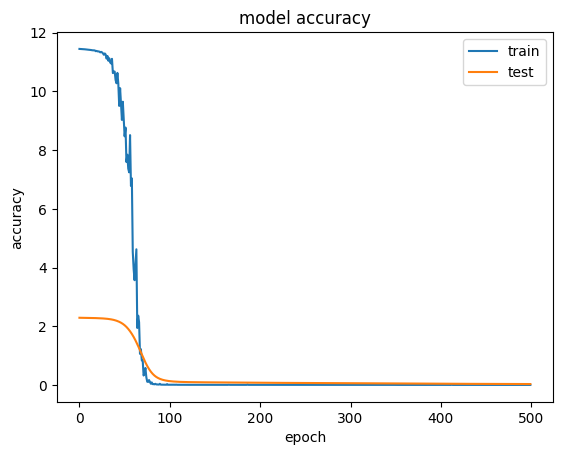

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

The data obtained is very bizarre, which could be a problem with the dataset, or due to overfitting, or something wrong with my algorithm, but I can't determine the exact cause and modify it at the moment.

I should keep this Notebook as part of my project exploration, but as a case of failed analysis, I will not use BRNN in my website